In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import scipy.io as sio
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.manifold import TSNE
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,roc_curve, auc
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.stats import skew, kurtosis
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.signal import spectrogram
from scipy.signal import cwt, morlet
import os
import h5py

os.environ["CUDA_VISIBLE_DEVICES"] = '15' #use GPU with ID=2, 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
## sub 3, 9, 11 只有61个channel，sub 5, 10, 18数据缺失
# 比较厉害的被试：2,4,6,7,8,12,13,16,17,21,22,23
# 定义需要加载的文件序号
subject_ids = [2,4,6,7,8,12,13,16,17,21,22,23]

# 定义 NonSpe 数据的后缀编号
nonspe_suffix = "3"

# 初始化空列表存储数据
spe_data_list = []
nonspe1_data_list = []

# 循环加载每个文件
for subject_id in subject_ids:
    try:
        # 构造文件名
        # 原始时间序列
        # filename = f'sub{subject_id}.mat'
        # upsample以后的数据
        # filename = f'upsample_sub{subject_id}.mat'
        # 增加样本量以后的数据
        filename = f'slice2_sub{subject_id}.mat'
        
        # 加载数据
        mat_data = sio.loadmat(filename)
        spe_data = mat_data['Spe_data']  # (channels, time, epochs)
        nonspe_key = f'NonSpe{nonspe_suffix}_data'
        nonspe1_data = mat_data[nonspe_key]  # (channels, time, epochs)
        
        # 删除第 20 行（Python 索引为 19）
        spe_data = np.delete(spe_data, 19, axis=0)  # 删除第 20 行的通道
        nonspe1_data = np.delete(nonspe1_data, 19, axis=0)  # 删除第 20 行的通道
        
        # 添加到列表
        spe_data_list.append(spe_data)
        nonspe1_data_list.append(nonspe1_data)
        
        print(f"Loaded data from {filename}, spe_data shape: {spe_data.shape}, nonspe1_data shape: {nonspe1_data.shape}")
    
    except KeyError as e:
        print(f"KeyError in {filename}: {e}")
    except FileNotFoundError as e:
        print(f"FileNotFoundError: {e}")

# 对所有数据进行拼接
spe_data_all = np.concatenate(spe_data_list, axis=2)  # 拼接 epoch 维度
nonspe1_data_all = np.concatenate(nonspe1_data_list, axis=2)  # 拼接 epoch 维度

# 打印拼接后数据的形状
print(f"Final spe_data shape: {spe_data_all.shape}")
print(f"Final nonspe1_data shape: {nonspe1_data_all.shape}")

Loaded data from slice2_sub2.mat, spe_data shape: (61, 1000, 1422), nonspe1_data shape: (61, 1000, 1398)
Loaded data from slice2_sub4.mat, spe_data shape: (61, 1000, 348), nonspe1_data shape: (61, 1000, 348)
Loaded data from slice2_sub6.mat, spe_data shape: (61, 1000, 330), nonspe1_data shape: (61, 1000, 342)
Loaded data from slice2_sub7.mat, spe_data shape: (61, 1000, 342), nonspe1_data shape: (61, 1000, 324)
Loaded data from slice2_sub8.mat, spe_data shape: (61, 1000, 330), nonspe1_data shape: (61, 1000, 342)
Loaded data from slice2_sub12.mat, spe_data shape: (61, 1000, 342), nonspe1_data shape: (61, 1000, 330)
Loaded data from slice2_sub13.mat, spe_data shape: (61, 1000, 330), nonspe1_data shape: (61, 1000, 348)
Loaded data from slice2_sub16.mat, spe_data shape: (61, 1000, 348), nonspe1_data shape: (61, 1000, 342)
Loaded data from slice2_sub17.mat, spe_data shape: (61, 1000, 354), nonspe1_data shape: (61, 1000, 342)
Loaded data from slice2_sub21.mat, spe_data shape: (61, 1000, 354),

In [13]:
## for sub 3 9 11
# 定义需要加载的文件序号
subject_ids = [3]

# 定义 NonSpe 数据的后缀编号
nonspe_suffix = "1"

# 初始化空列表存储数据
spe_data_list = []
nonspe1_data_list = []

# 循环加载每个文件
for subject_id in subject_ids:
    try:
        # 构造文件名
        # 原始时间序列
        # filename = f'sub{subject_id}.mat'
        # upsample以后的数据
        # filename = f'upsample_sub{subject_id}.mat'
        # 增加样本量以后的数据
        filename = f'slice2_sub{subject_id}.mat'
        
        # 加载数据
        mat_data = sio.loadmat(filename)
        spe_data = mat_data['Spe_data']  # (channels, time, epochs)
        nonspe_key = f'NonSpe{nonspe_suffix}_data'
        nonspe1_data = mat_data[nonspe_key]  # (channels, time, epochs)
        
        # 添加到列表
        spe_data_list.append(spe_data)
        nonspe1_data_list.append(nonspe1_data)
        
        print(f"Loaded data from {filename}, spe_data shape: {spe_data.shape}, nonspe1_data shape: {nonspe1_data.shape}")
    
    except KeyError as e:
        print(f"KeyError in {filename}: {e}")
    except FileNotFoundError as e:
        print(f"FileNotFoundError: {e}")

# 对所有数据进行拼接
spe_data_all = np.concatenate(spe_data_list, axis=2)  # 拼接epoch维度
nonspe1_data_all = np.concatenate(nonspe1_data_list, axis=2)  # 拼接epoch维度

# 打印拼接后数据的形状
print(f"Final spe_data shape: {spe_data_all.shape}")
print(f"Final nonspe1_data shape: {nonspe1_data_all.shape}")

Loaded data from slice2_sub22.mat, spe_data shape: (62, 1000, 354), nonspe1_data shape: (62, 1000, 342)
Final spe_data shape: (62, 1000, 354)
Final nonspe1_data shape: (62, 1000, 342)


In [3]:
class EEGNetModel(nn.Module): 
    def __init__(self, chans=61, classes=2, time_points=1000, temp_kernel=32,
                 f1=16, f2=32, d=2, pk1=8, pk2=16, dropout_rate=0.5, max_norm1=1, max_norm2=0.25):
        super(EEGNetModel, self).__init__()

        # 计算全连接层输入的特征数量
        linear_size = (time_points // (pk1 * pk2)) * f2

        # 第一层：时间滤波器
        self.block1 = nn.Sequential(
            nn.Conv2d(1, f1, (1, temp_kernel), padding='same', bias=False),
            nn.BatchNorm2d(f1),
        )

        # 第二层：空间滤波器（深度卷积）
        self.block2 = nn.Sequential(
            nn.Conv2d(f1, d * f1, (chans, 1), groups=f1, bias=False),  # 深度卷积
            nn.BatchNorm2d(d * f1),
            nn.ELU(),
            nn.AvgPool2d((1, pk1)),
            nn.Dropout(dropout_rate)
        )

        # 第三层：可分离卷积
        self.block3 = nn.Sequential(
            nn.Conv2d(d * f1, f2, (1, 16),  groups=f2, bias=False, padding='same'),  # 可分离卷积
            nn.Conv2d(f2, f2, kernel_size=1, bias=False),  # 点卷积
            nn.BatchNorm2d(f2),
            nn.ELU(),
            nn.AvgPool2d((1, pk2)),
            nn.Dropout(dropout_rate)
        )

        # 展平并连接到全连接层
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(linear_size, classes)

        # 应用 max_norm 约束到第二层
        self._apply_max_norm(self.block2[0], max_norm1)

        # 应用 max_norm 约束到全连接层
        self._apply_max_norm(self.fc, max_norm2)

    def _apply_max_norm(self, layer, max_norm):
        for name, param in layer.named_parameters():
            if 'weight' in name:
                param.data = torch.renorm(param.data, p=2, dim=0, maxnorm=max_norm)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [9]:
spe_data = spe_data_all
nonspe1_data = nonspe1_data_all
# 获取维度信息
num_channels, num_timepoints, spe_epochs = spe_data.shape
_, _, nonspe1_epochs = nonspe1_data.shape

# 创建类别标签 (0 表示专家组，1 表示非专家组)
spe_labels = np.zeros(spe_epochs, dtype=int)  # shape: (spe_epochs,)
nonspe1_labels = np.ones(nonspe1_epochs, dtype=int)  # shape: (nonspe1_epochs,)

# 数据合并
X = np.concatenate([spe_data, nonspe1_data], axis=2)  # shape: (62, 4000, total_epochs)
y = np.concatenate([spe_labels, nonspe1_labels])  # shape: (total_epochs,)

# 调整数据形状为 EEGNet 的输入格式
X = np.transpose(X, (2, 0, 1))  # shape: (total_epochs, 62, 4000)
X = np.expand_dims(X, axis=1)  # shape: (total_epochs, 1, 62, 4000)

# 数据归一化
X = (X - np.mean(X, axis=-1, keepdims=True)) / np.std(X, axis=-1, keepdims=True)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=4)

# 转换为 PyTorch 数据格式
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

# X_train = torch.tensor(X_train, dtype=torch.float32)
# y_train = torch.tensor(y_train, dtype=torch.long)
# X_test = torch.tensor(X_test, dtype=torch.float32)
# y_test = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Printing the sizes
print("Size of X_train:", X_train.size())
print("Size of X_test:", X_test.size())
print("Size of y_train:", y_train.size())
print("Size of y_test:", y_test.size())

Size of X_train: torch.Size([8318, 1, 61, 1000])
Size of X_test: torch.Size([2080, 1, 61, 1000])
Size of y_train: torch.Size([8318])
Size of y_test: torch.Size([2080])


In [ ]:
# 创建模型实例
model = EEGNetModel()
model = model.to(device)

# 设置优化器和损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 定义存储损失和准确率的列表
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# 训练模型
num_epochs = 100
for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # 反向传播和优化
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # 测试阶段
    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_loss = test_running_loss / len(test_loader)
    test_acc = 100 * test_correct / test_total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(
        f"Epoch [{epoch+1}/{num_epochs}] | "
        f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}% | "
        f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%"
    )


Epoch [1/100] | Train Loss: 0.6953, Train Accuracy: 51.06% | Test Loss: 0.6904, Test Accuracy: 51.78%
Epoch [2/100] | Train Loss: 0.6924, Train Accuracy: 52.22% | Test Loss: 0.6901, Test Accuracy: 51.49%
Epoch [3/100] | Train Loss: 0.6860, Train Accuracy: 54.86% | Test Loss: 0.6829, Test Accuracy: 54.81%
Epoch [4/100] | Train Loss: 0.6808, Train Accuracy: 56.71% | Test Loss: 0.6772, Test Accuracy: 55.96%
Epoch [5/100] | Train Loss: 0.6777, Train Accuracy: 57.13% | Test Loss: 0.6747, Test Accuracy: 57.36%
Epoch [6/100] | Train Loss: 0.6711, Train Accuracy: 58.99% | Test Loss: 0.6672, Test Accuracy: 58.56%
Epoch [7/100] | Train Loss: 0.6653, Train Accuracy: 59.25% | Test Loss: 0.6626, Test Accuracy: 60.29%
Epoch [8/100] | Train Loss: 0.6659, Train Accuracy: 59.82% | Test Loss: 0.6668, Test Accuracy: 59.09%
Epoch [9/100] | Train Loss: 0.6585, Train Accuracy: 60.54% | Test Loss: 0.6605, Test Accuracy: 59.57%
Epoch [10/100] | Train Loss: 0.6586, Train Accuracy: 60.71% | Test Loss: 0.6574, T

In [ ]:
run=1
model_save_dir = f"./networks/trained_models_subjects_{'_'.join(map(str, subject_ids))}_{nonspe_suffix}"
os.makedirs(model_save_dir, exist_ok=True)  # 创建保存模型的目录


# 保存训练好的模型
model_save_path = os.path.join(model_save_dir, f"model_run_{run}.pth")
torch.save(model.state_dict(), model_save_path)
print(f"Model for Run {run} saved to {model_save_path}.")

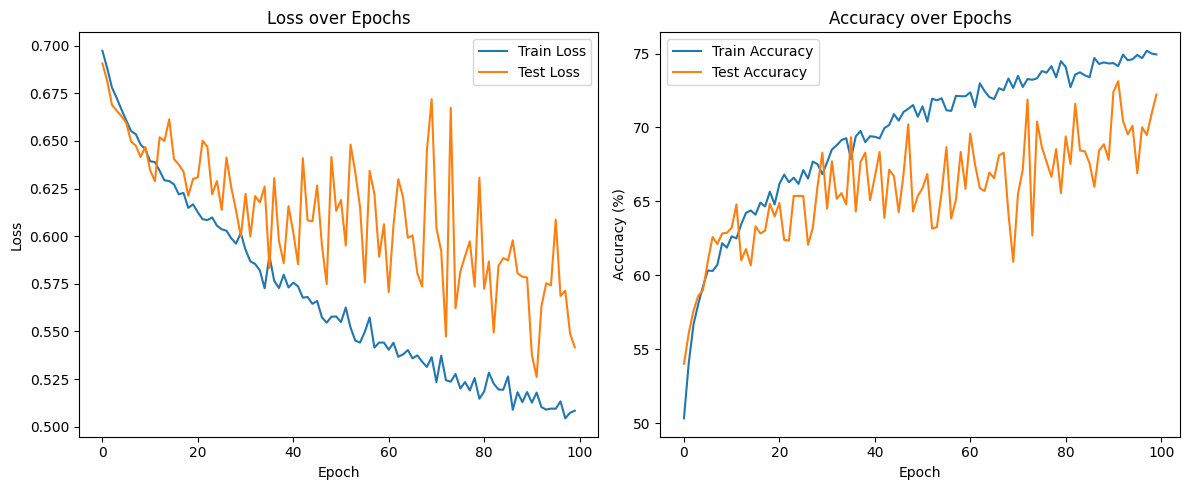

In [6]:
# 绘制损失和准确率曲线
plt.figure(figsize=(12, 5))

# 绘制损失曲线
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
# 计算混淆矩阵
y_true = y_test.numpy()  # 真实标签
y_pred = []
model.eval()
with torch.no_grad():
    for X_batch, _ in test_loader:
        outputs = model(X_batch)
        y_pred.extend(outputs.argmax(1).numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Expert', 'Non-Expert'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.